# Mandelbrot set visualization

A vanilla python/numpy implementation of a Mandelbrot set visualizer.

The code has been liberally inspired by [this implementation by Jean-François Puget](https://www.ibm.com/developerworks/community/blogs/jfp/entry/My_Christmas_Gift?lang=en).

Follow the [above link](https://www.ibm.com/developerworks/community/blogs/jfp/entry/My_Christmas_Gift?lang=en) also for more information on the Maldebrot set and the colorization procedure.

In [1]:
import warnings
import numpy as np
from matplotlib import colors, pyplot as plot

%matplotlib inline

Let's define a procedure to sample a region of the complex plane:

In [2]:
pois = {  # points of interest
    'full': (-2.0, 0.5, -1.25, 1.25),
    'valley': (-0.8, -0.7, 0.0, 0.1),
    'sea_horses': (-0.755, -0.745, 0.06, 0.07),
    'sea_horse': (-0.75, -0.747, 0.063, 0.066),
    'sea_horse_tail': (-0.749, -0.748, 0.065, 0.066),
    'black_dot': (-0.74877,-0.74872,0.06505,0.06510)}


def complex_grid(xmin, xmax, ymin, ymax, res=256):
    xx = np.linspace(xmin, xmax, num=res)
    yy = np.linspace(ymin, ymax, num=res)
    x, y = np.meshgrid(xx, yy)
    return x + 1j * y

Here's the most crude, synthetic and straighforward implementation:

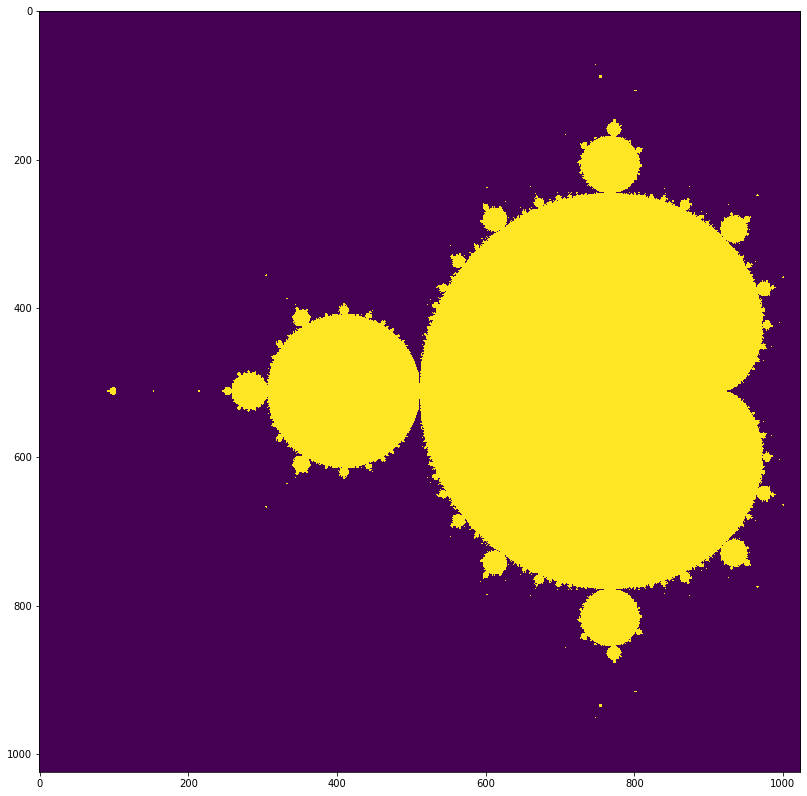

In [3]:
def mandelbrot_boolean(coords, max_iterations=256):

    values = coords.copy()
    for _ in range(max_iterations):        
        values = values ** 2 + coords
    return abs(values) < 2


plot.figure(figsize=(14, 14))
warnings.filterwarnings('ignore')  # ignore warnings about overflows
plot.imshow(mandelbrot_boolean(complex_grid(*pois['full'], res=1024)))
warnings.filterwarnings('default')
plot.show()

Let's keep track and visualize the number of iterations required to diverge:

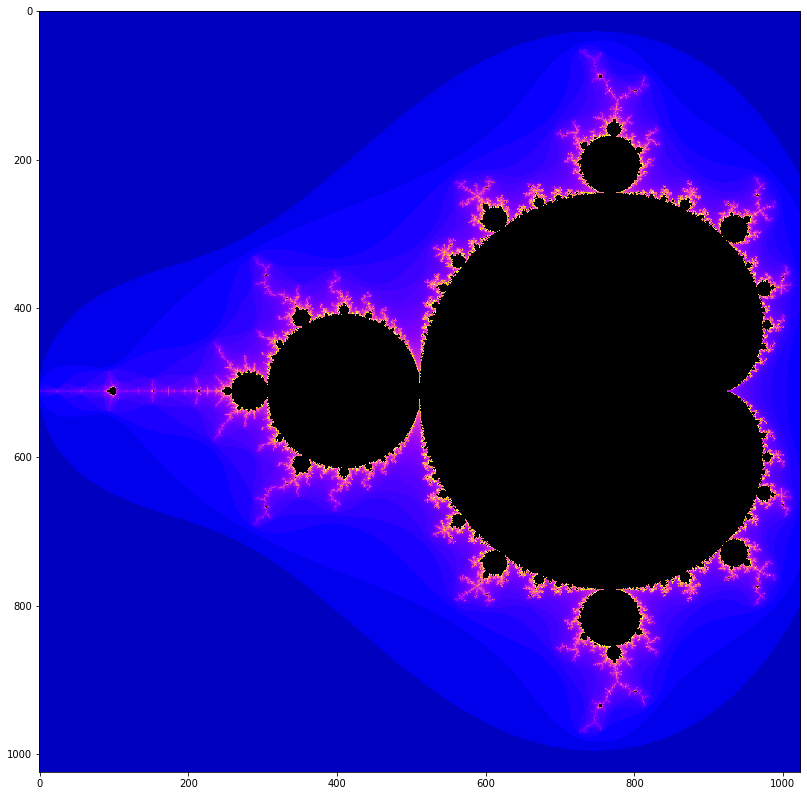

In [4]:
def mandelbrot_discrete(coords, max_iterations=256):

    values = coords.copy()
    iteration_count = np.zeros_like(values, np.float)
    for iteration in range(max_iterations):

        nya = iteration_count == 0  # not yet assigned
        values[nya] = values[nya] ** 2 + coords[nya]
        
        abs_values = np.abs(values)
        diverged = abs_values > 2
        jd = np.logical_and(nya, diverged)  # just diverged        
        iteration_count[jd] = iteration

    return iteration_count


plot.figure(figsize=(14, 14))
image = mandelbrot_discrete(complex_grid(*pois['full'], res=1024))
plot.imshow(image, cmap='gnuplot2', norm=colors.PowerNorm(0.3))
plot.show()

To avoid banding effects, we take into account not just the iteration number but the value as well.

See [this implementation by Jean-François Puget](https://www.ibm.com/developerworks/community/blogs/jfp/entry/My_Christmas_Gift?lang=en) for an explanation of the technique.

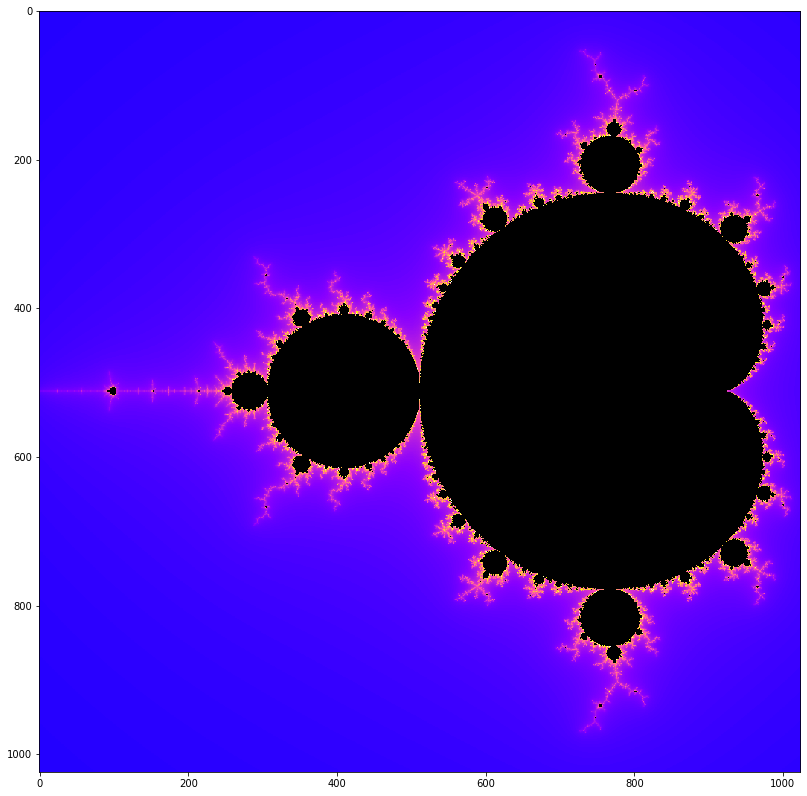

In [5]:
def mandelbrot_continuous(coords, max_iterations=256):

    horizon = 2.0 ** 40
    log_horizon = np.log(np.log(horizon)) / np.log(2)
    
    values = coords.copy()
    iteration_count = np.zeros_like(values, np.float)
    for iteration in range(max_iterations):
        
        nya = iteration_count == 0  # not yet assigned
        values[nya] = values[nya] ** 2 + coords[nya]
        
        abs_values = np.abs(values)
        diverged = abs_values > horizon
        jd = np.logical_and(nya, diverged)  # just diverged        
        iteration_count[jd] = iteration - np.log(np.log(abs_values[jd])) / np.log(2) + log_horizon        
    
    return iteration_count


plot.figure(figsize=(14, 14))
image = mandelbrot_continuous(complex_grid(*pois['full'], res=1024))
plot.imshow(image, cmap='gnuplot2', norm=colors.PowerNorm(0.3))
plot.show()

More pretty pictures:

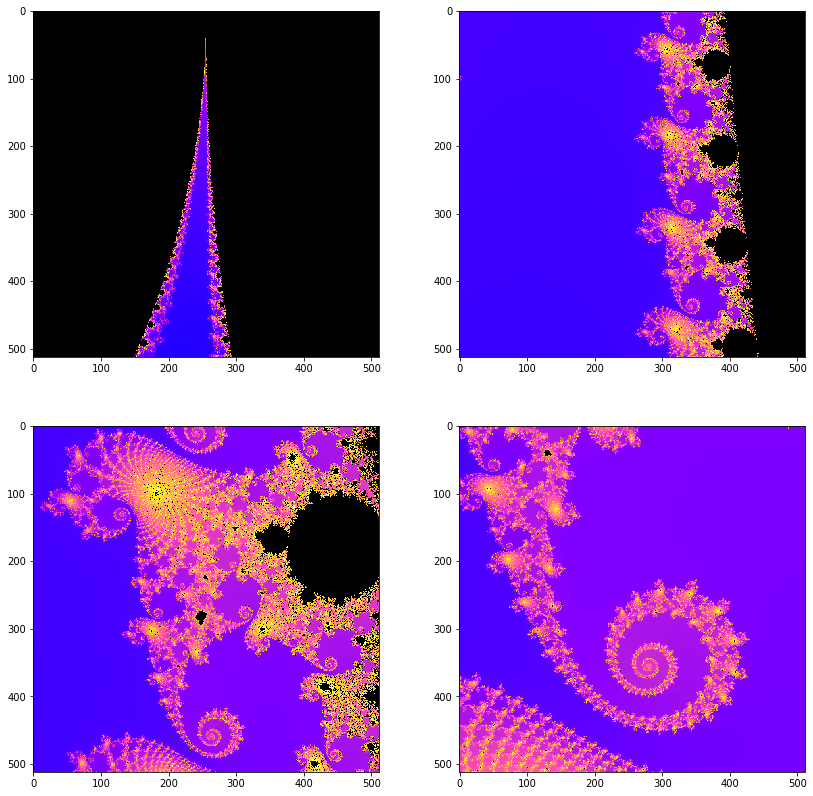

In [6]:
plot.figure(figsize=(14, 14))
for index, detail in enumerate(('valley', 'sea_horses', 'sea_horse', 'sea_horse_tail')):
    
    plot.subplot(221 + index)
    image = mandelbrot_continuous(complex_grid(*pois[detail], res=512), 2048)
    plot.imshow(image, cmap='gnuplot2', norm=colors.PowerNorm(0.3))

plot.show()